#
<FONT size="10pt"> <center>Projet 4 : Nettoyage des données</center></FONT>. 

Vous travaillez pour la ville de **Seattle**. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la **consommation et aux émissions des bâtiments non destinés à l’habitation.**

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les **émissions de CO2** et **la consommation totale d’énergie** de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur **les données structurelles des bâtiments** (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

    - Réaliser une courte analyse exploratoire.
    - Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

**Livrables :**

    - Un notebook de l'analyse exploratoire mis au propre et annoté.
    - Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.
    - Un support de présentation pour la soutenance (entre 15 et 25 slides).

# 1 : Librairies et options

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm
import missingno as msno
import math
import random
import scipy
import os

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

pd.set_option('mode.chained_assignment', None) # Pour ne pas avoir de message d'erreur quand on crée nouvelle df à partir d'une autre (app)

# 2 : Ouverture des données

In [2]:
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')
df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

# 3 : Info générales et recherche des NaNs

## 3.1 : Info Générales

In [3]:
# Taille de la DF :
df.shape

(3376, 46)

In [4]:
# Info de la DF :
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [5]:
# Nb de duplicatas :
df.duplicated().sum()

0

## 3.2 : Etude des NaNs

In [6]:
# Pourcentage de NaNs par colonne :
(df.notna().mean()*100).round(2)

OSEBuildingID                      100.00
DataYear                           100.00
BuildingType                       100.00
PrimaryPropertyType                100.00
PropertyName                       100.00
Address                            100.00
City                               100.00
State                              100.00
ZipCode                             99.53
TaxParcelIdentificationNumber      100.00
CouncilDistrictCode                100.00
Neighborhood                       100.00
Latitude                           100.00
Longitude                          100.00
YearBuilt                          100.00
NumberofBuildings                   99.76
NumberofFloors                     100.00
PropertyGFATotal                   100.00
PropertyGFAParking                 100.00
PropertyGFABuilding(s)             100.00
ListOfAllPropertyUseTypes           99.73
LargestPropertyUseType              99.41
LargestPropertyUseTypeGFA           99.41
SecondLargestPropertyUseType      

- **Une colonne vide (comments), beaucoup de colonnes à 100% ou presque de remplissage.**
- **Quelques colonnes à 25% ou 50% de remplissage.**

In [7]:
#Pourcentage de NaNs :
NbNaNs = df.isna().sum().sum()
NbCases = df.shape[0]*df.shape[1]

(NbNaNs/NbCases*100).round(2)

12.85

- **Il n'y a que 13% de valeurs non remplies dans cette DF.**

In [8]:
# Suppression de la colonne vide:
df = df.dropna(how = 'all', axis = 1)

In [9]:
# Lignes vides au niveau des colonnes valeurs de consommation énégétique :
ConsEner = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',]
DfConsEner = (df[ConsEner].isna().mean(axis = 1)*100).to_frame()
DfConsEner = DfConsEner.round(2)
DfConsEner.reset_index().groupby(0).count().T

0      0.00    9.09    18.18   63.64   100.00
index    3364       2       1       4       5

- **IL y a 5 lignes 100% vides en NaNs.**
- **Mais y a t'il des lignes vides avec des 0 en consommation.**

In [10]:
# Suppression de ces lignes vides :
IndexVides = DfConsEner[DfConsEner[0] == 100].index
df = df.drop(index = IndexVides).reset_index(drop = True)

In [11]:
# Zero Consommation d'énergie :
ZeroConso = df[ConsEner].sum(axis = 1).round(2).to_frame()
ZeroConso[ZeroConso[0] == 0]

0
28    0.0
152   0.0
304   0.0
745   0.0
758   0.0
1359  0.0
1547  0.0

- **Il y a 7 construction qui ne consomme rien.**

In [12]:
# Suppression de ces lignes :
IndexVides = ZeroConso[ZeroConso[0] == 0].index
df = df.drop(index = IndexVides)

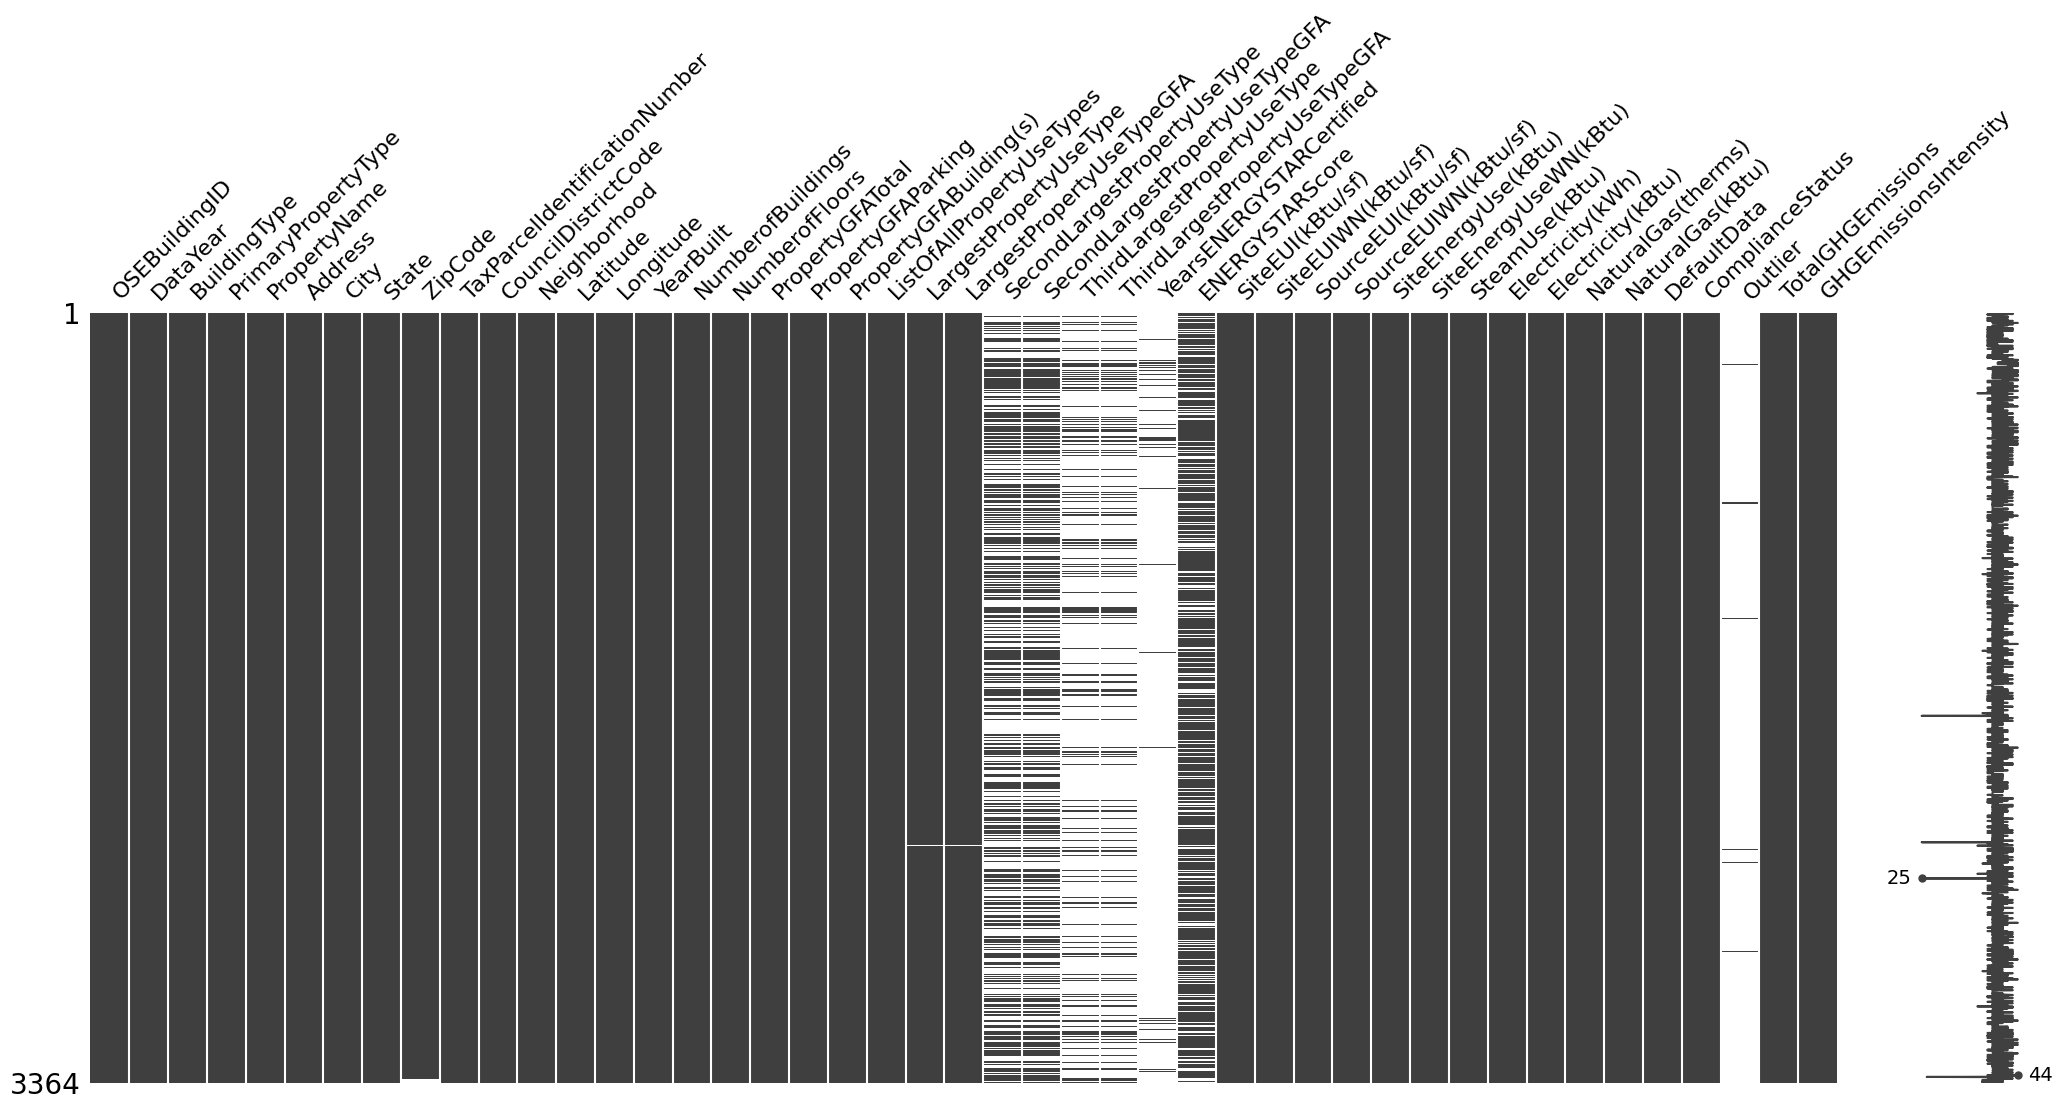

In [13]:
# Visualisation du remplissage avec missingo:
%matplotlib inline
msno.matrix(df)
plt.show()

- **La DF est bien remplie hormis pour six colonnes.**

In [14]:
# Répartition des variables quantitiaves et qualitatives :
print('Il y a', len(df.select_dtypes(exclude = 'object').columns), 'variables numériques.')
print('Il y a', len(df.select_dtypes(include = 'object').columns), 'variables qualitatives.')

Il y a 30 variables numériques.
Il y a 15 variables qualitatives.


In [15]:
df.select_dtypes(include = 'object')

BuildingType PrimaryPropertyType  \
0         NonResidential               Hotel   
1         NonResidential               Hotel   
2         NonResidential               Hotel   
3         NonResidential               Hotel   
4         NonResidential               Hotel   
...                  ...                 ...   
3366  Nonresidential COS              Office   
3367  Nonresidential COS               Other   
3368  Nonresidential COS               Other   
3369  Nonresidential COS  Mixed Use Property   
3370  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address     City State  \
0                    Mayflower park hotel     405 Olive way  Seattle    WA   
1                         Paramount Hotel   724 Pine street  Seattle    WA   
2                 5673-The Westin Seattle   1900 5th Avenue  Seattle    WA   
3                               HOTEL MAX    620 STEWART ST  Seattle    WA   
4             WARWICK SEATTLE HOTEL (ID8)     401 LENORA ST  Seattle    WA   
...                                   ...               ...      ...   ...   
3366                Horticulture building  1600 S Dakota St  Seattle    WA   
3367  International district/Chinatown CC     719 8th Ave S  Seattle    WA   
3368                      Queen Anne Pool    1920 1st Ave W  Seattle    WA   
3369          South Park Community Center    8319 8th Ave S  Seattle    WA   
3370          Van Asselt Community Center  2820 S Myrtle St  Seattle    WA   

     TaxParcelIdentificationNumber           Neighborhood  \
0                       0659000030               DOWNTOWN   
1                       0659000220               DOWNTOWN   
2                       0659000475               DOWNTOWN   
3                       0659000640               DOWNTOWN   
4                       0659000970               DOWNTOWN   
...                            ...                    ...   
3366                    1624049080       GREATER DUWAMISH   
3367                    3558300000               DOWNTOWN   
3368                    1794501150  MAGNOLIA / QUEEN ANNE   
3369                    7883603155       GREATER DUWAMISH   
3370                    7857002030       GREATER DUWAMISH   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
3366                                             Office   
3367                                 Other - Recreation   
3368  Fitness Center/Health Club/Gym, Other - Recrea...   
3369  Fitness Center/Health Club/Gym, Food Service, ...   
3370  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType    SecondLargestPropertyUseType  \
0                     Hotel                             NaN   
1                     Hotel                         Parking   
2                     Hotel                             NaN   
3                     Hotel                             NaN   
4                     Hotel                         Parking   
...                     ...                             ...   
3366                 Office                             NaN   
3367     Other - Recreation                             NaN   
3368     Other - Recreation  Fitness Center/Health Club/Gym   
3369     Other - Recreation  Fitness Center/Health Club/Gym   
3370     Other - Recreation  Fitness Center/Health Club/Gym   

     ThirdLargestPropertyUseType YearsENERGYSTARCertified  \
0                            NaN                      NaN   
1                     Restaurant                      NaN   
2                            NaN                      NaN   
3                            NaN                      N

# 4 : Etude des variables qualitatives

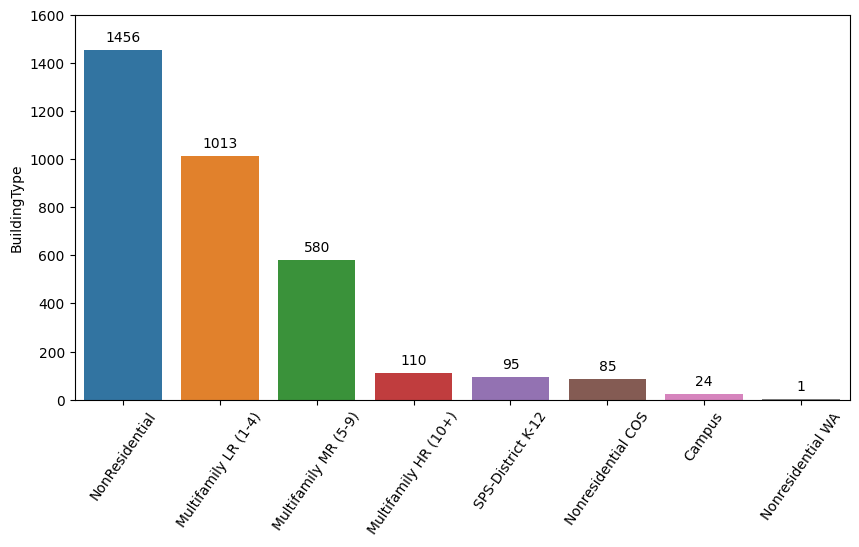

In [16]:
# BuildingType :
Graph1 = df['BuildingType'].value_counts().to_frame()

ax = plt.figure(figsize=(10,5))
ax = sns.barplot(x = Graph1.index, y = Graph1['BuildingType'])
ax.bar_label(ax.containers[0], labels = list(Graph1['BuildingType']), padding=4)
plt.xticks(rotation = 55)
ax.margins(y=0.1)
plt.show()

# Suppression des Multifamilly :
df = df[~df['BuildingType'].str.contains('Multifamily')].reset_index(drop = True)

- **Utile car on veut travailler que sur les batiments NonResidential.**
- **On supprime donc les Multifamily.**

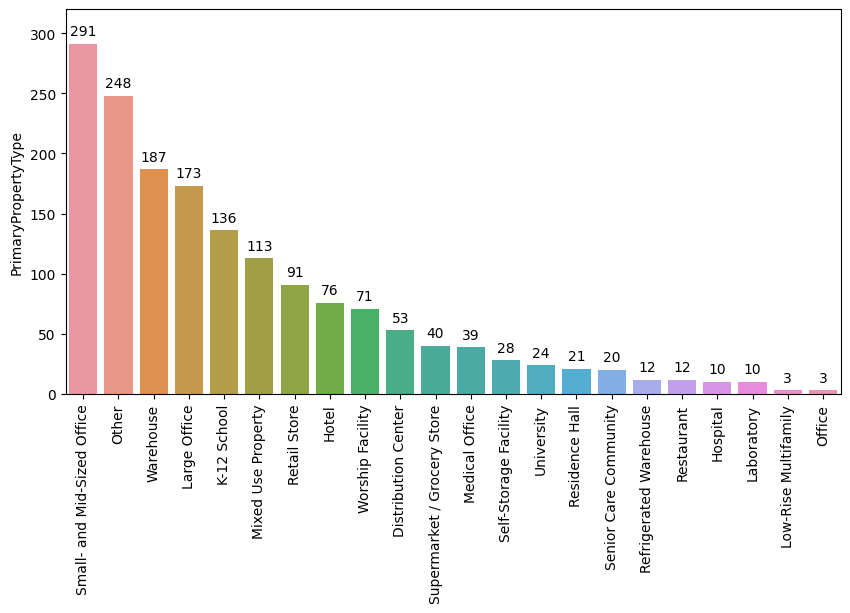

In [17]:
# Type de Propriété principale :
Graph2 = df['PrimaryPropertyType'].value_counts().to_frame()

ax = plt.figure(figsize=(10,5))
ax = sns.barplot(x = Graph2.index, y = Graph2['PrimaryPropertyType'])
ax.bar_label(ax.containers[0], labels = list(Graph2['PrimaryPropertyType']), padding=4)
plt.xticks(rotation = 90)
ax.margins(y=0.1)
plt.show()

# Suppression des Multifamilly :
df = df[~df['PrimaryPropertyType'].str.contains('Multifamily|Residence Hall')].reset_index(drop = True)

- **Permet de savoir quel est le type de batiment principal.**
- **Permet de savoir a quoi correspond chaque type de building.**
- **Il reste des MULTFAMILY.**

In [18]:
# Noms des batiments :
print(df['PropertyName'].nunique())
print(df[df['PropertyName'].duplicated(keep = False)]['PropertyName'])

del df['PropertyName']

1633
158           South Park
813       Canal Building
917     Bayview Building
949           South Park
992       Canal Building
1110         Airport Way
1128    Bayview Building
1131         Airport Way
Name: PropertyName, dtype: object


- **Noms des batiments peut utile pour prédire une consommation énergétique.**
- **1538noms pour 1541 constructions.**

In [19]:
# Addresses :
df['Address'].unique()
df['ZipCode'].unique()
df['CouncilDistrictCode'].unique()
df['Neighborhood'].unique()
df['Latitude'].unique()
df['Longitude'].unique()

array([-122.33799, -122.33393, -122.3381 , ..., -122.35784, -122.32431,
       -122.29536])

- **Les adresses des batiments.**
- **Il manque quelques ZipCode.**
- **Informations utiles pour la situation géographique.**

In [20]:
# Coordonnées de géolocalisation :
# Def pour regrouper la Longitude et la Latitude :
def GeoLoc(value):
    Lat, Long = value['Latitude'], value['Longitude']
    return ([Lat, Long])

df.insert(5, "Coordonnees", 0, allow_duplicates=False)
df['Coordonnees'] = df[['Latitude','Longitude']].apply(GeoLoc, axis = 1)
df.reset_index(drop = True, inplace = True)

# Suppression des deux colonnes seules :
del df['Latitude']
del df['Longitude']

# Répartition des coordonnées par district + localisation des données sans ZipCode :
data = df[df['ZipCode'].notna()]
datanan = df[df['ZipCode'].isna()].reset_index(drop = True)
couleurs = ['red','green','yellow','orange','white','cyan','gold']

m = folium.Map(location = data.Coordonnees[0], zoom_start=11)

for District, couleur in zip((data['CouncilDistrictCode'].unique()),couleurs):
    zone = data[data['CouncilDistrictCode'] == District]
    zone.reset_index(drop = True, inplace = True)
    for i in range(len(zone)): 
        folium.Circle(location = zone.Coordonnees[i], radius=10, color=couleur).add_to(m)

for j in range(len(datanan)):
        folium.Circle(location = datanan.Coordonnees[j], radius=100, color= 'black').add_to(m)
        
m

- **Toutes les coordonnées sont bien à Seattle.**
- **Les batiments sans ZipCode (en noir) sont présent dans un peut tous les District, la colonne coordonnées peut remplacer cette colonne.**
- **Les coordonnées sont plus intéressantes à utiliser que les adresses postales.**

In [21]:
# Suppression des adresses postales pour ne garder que les districts :
del df['Address']
del df['ZipCode']

In [22]:
# Quartiers : 
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x.upper())
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x.replace(' NEIGHBORHOODS',''))
df['Neighborhood'].nunique()

couleurs = ['red','green','yellow','orange','black','cyan','gold', 'purple', 'grey', 'white', 'brown', 'crimson','lime']

m = folium.Map(location = data.Coordonnees[0], zoom_start=11)

for NeighBorhood, couleur in zip((df['Neighborhood'].unique()),couleurs):
    zone = data[data['Neighborhood'] == NeighBorhood]
    zone.reset_index(drop = True, inplace = True)
    for i in range(len(zone)): 
        folium.Circle(location = zone.Coordonnees[i], radius=10, color=couleur).add_to(m)
m

- **Erreurs de Typo min/maj et ajout du mot Neighborhoods.**
- **Il reste donc 13 quartiers.**
- **IL y a un mélange entre les quartiers rouges et les jaunes.**
- **C'est un autre type de découpage.**

In [23]:
# Ville et Etat : 
print(df['State'].unique())
print(df['City'].unique())

del df['State']
del df['City']

['WA']
['Seattle']


- **C'est toujours la même ville et le même Etats de Washington.**

In [24]:
# Toutes les propriétés pour chaque construction :
df['ListOfAllPropertyUseTypes'].unique()

del df['ListOfAllPropertyUseTypes']

- **Beaucoup de types de propriètés différents à voir car compliqué à analyser mais la consommation peut différer d'un type de batiment à un autre, difficile à dummiser.**

In [25]:
# Type de propriété et surface des 3 plus gros batiments du pool :
df['LargestPropertyUseType'].unique()
df['SecondLargestPropertyUseType'].unique()
df['ThirdLargestPropertyUseType'].unique()

array([nan, 'Restaurant', 'Swimming Pool', 'Data Center', 'Office',
       'Retail Store', 'Other - Entertainment/Public Assembly',
       'Non-Refrigerated Warehouse', 'Other', 'Distribution Center',
       'Food Service', 'Other - Services', 'Medical Office', 'Parking',
       'Other - Utility', 'K-12 School', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Pre-school/Daycare',
       'Convenience Store without Gas Station', 'Financial Office',
       'Other - Restaurant/Bar', 'Other - Education',
       'Multifamily Housing', 'Laboratory', 'Bank Branch', 'Hotel',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Other - Recreation', 'Self-Storage Facility',
       'Other - Technology/Science', 'Refrigerated Warehouse',
       'Bar/Nightclub', 'Manufacturing/Industrial Plant',
       'Other/Specialty Hospital', 'Fast Food Restaurant',
       'Worship Facility', 'Supermarket/Grocery Store', 'Strip Mall',
       'Vocational School'], dtype=object)

- **Intéressant si on suppose que les plus grosses constructions consomment le plus.**
- **Il s'agit de certaines des colonnes les plus vides ce qui peut ce comprendre vu qu'il n'y a pas toujours de 2nd ou 3éme batiment.**
- **Par contre il y a du vide dans le batiment principal ce qui n'est pas normal.**
- **Les données par batiments isolés sont plus intéressant que en pool mais a t'on les données de consommation pour chaque batiements.**

In [26]:
# Vide dans batiment principal : 
df[df['LargestPropertyUseType'].isna()]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
342             496      2016  NonResidential        Self-Storage Facility   
808           21103      2016  NonResidential                        Hotel   
1333          25568      2016  NonResidential  Small- and Mid-Sized Office   
1350          25711      2016  NonResidential                   Restaurant   

                 Coordonnees TaxParcelIdentificationNumber  \
342    [47.66838, -122.3931]                    1175001235   
808   [47.61203, -122.34165]                    1977201140   
1333  [47.64747, -122.34086]                    4088804565   
1350  [47.59697, -122.32474]                    5247802410   

      CouncilDistrictCode Neighborhood  YearBuilt  NumberofBuildings  \
342                     6      BALLARD       1946                2.0   
808                     7     DOWNTOWN       1910                1.0   
1333                    4   LAKE UNION       2008                1.0   
1350                    2     DOWNTOWN       1913                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
342                2            111445                   0   
808                8             61721                   0   
1333               4             48350                   0   
1350               3             28800                   0   

      PropertyGFABuilding(s) LargestPropertyUseType  \
342                   111445                    NaN   
808                    61721                    NaN   
1333                   48350                    NaN   
1350                   28800                    NaN   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
342                         NaN                          NaN   
808                         NaN                          NaN   
1333                        NaN                          NaN   
1350                        NaN                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
342                               NaN                         NaN   
808                               NaN                         NaN   
1333                              NaN                         NaN   
1350                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
342                              NaN                      NaN   
808                              NaN                      NaN   
1333                             NaN                      NaN   
1350                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
342               NaN         47.799999           51.000000   
808              93.0         52.200001           53.500000   
1333             45.0         72.199997           74.699997   
1350              NaN         31.200001           32.500000   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
342           103.000000            106.400002         5.697472e+06   
808           150.399994            154.399994         2.897080e+06   
1333          226.600006            234.600006         3.168131e+06   
1350           62.000000             62.799999         8.999242e+05   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
342            6.076957e+06             0.0       881452.0000   
808            2.968430e+06             0.0       742846.3750   
1333           3.280956e+06             0.0       928526.0000   
1350           9.358332e+05             0.0       118085.2969   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
342           3007514.0        26899.582030         2689958.0        False   
808           2534592.0         3624.875244          362488.0        False   
1333          3168131.0            0.000000               0.0        False   
1350           402907.0         4970.169922          

- **Il y a 3 construction qui n'ont que 1 batiment donc ce n'est pas grave par contre la construction avec 2 batiments sera un problème.**
- **Mais ces colonnes sont elles exploitables si on a pas les données de consommation par batiment mais uniquement une consommation globale.**

In [27]:
# Remplassement des Nans pour les Building ayant 0 Largest PropertyUseType :
ListIndex = df[df['LargestPropertyUseType'].isna() & (df['NumberofBuildings'] == 1)].index
for Ind in ListIndex:
    df['LargestPropertyUseTypeGFA'].iloc[Ind:Ind+1] = df['PropertyGFABuilding(s)'].iloc[Ind:Ind+1]
    df['LargestPropertyUseType'].iloc[Ind:Ind+1] = df['PrimaryPropertyType'].iloc[Ind:Ind+1]
    
# Suppression des autres ne pouvant récupérer les infos:

df = df[~df['LargestPropertyUseType'].isna()].reset_index(drop = True)

In [28]:
# Année de certification de l'NRJ Stars score:
print(df['YearsENERGYSTARCertified'].unique())
print(df['YearsENERGYSTARCertified'].isna().mean().round(2))

# Note moyenne NRJ StarScore certifié et non certifié:
print(df[df['YearsENERGYSTARCertified'].isna()]['ENERGYSTARScore'].mean().round(2))
print(df[df['YearsENERGYSTARCertified'].notna()]['ENERGYSTARScore'].mean().round(2))

del df['YearsENERGYSTARCertified']

[nan '2016' '2014' '2012' '20172015'
 '2017201620152014201320122011201020092008' '201020092007' '201720102007'
 '20162015' '20152014201220112009' '201220092008'
 '201620152014201320112010200920072000' '201620092008' '201620142012'
 '20162015201420122008'
 '2016201520142013201220112010200920082007200620052004' '201520142013'
 '2014201320112010200920082007' '2016201520142013'
 '2017201620152014201320112008' '201720162015201420132008'
 '20162015201320122010' '2015201320122010' '20162011201020092008' '2007'
 '2010' '20172016201520092008' '2017201320092008' '2015' '2017'
 '2017201120102007' '201720162014201320122011201020092007'
 '201720152014201220102008' '20092005' '2017201520142013' '201620152012'
 '2012201020072006' '20112009' '2009' '201620152014201320092008'
 '201620152014201320112009' '2016201520142013201220112010' '201720162012'
 '20102008' '201620142012201120082007' '2017201520142013201120092008'
 '2016201520142013201220102009' '2016201120102009' '2016201520122009'
 '20162012' '201

- **Liste des années de certification, pas trés utile.**
- **Variable Vide à 94%**
- **Pour être certifié il faut avoir plus de 75, on remarque que la moyenne des certifiés est à 85 et les non certifiés sont à 63.6.**

In [29]:
# Etude des Outliers :
print(len(df[df['Outlier'].notna()]))
df = df[df['Outlier'].isna()]

del df['Outlier']

16


- def : Si une propriété est une valeur aberrante élevée ou basse (O/N)
- **Par rapport à quoi???**

In [30]:
# Etude du DefaultData :
df[df['DefaultData'] == True][['LargestPropertyUseType','ComplianceStatus']].value_counts()

print(len(df[df['DefaultData'] == True]))

df = df[df['DefaultData'] == False].reset_index(drop = True)

del df['DefaultData']
del df['ComplianceStatus']

85


- Def : La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété.
- Def : Si une propriété a satisfait aux exigences d'analyse comparative énergétique pour l'année de déclaration en cours.
- **Oui mais laquelle???**

# 5 : Etude des variables quantitatives hors consommation 

In [31]:
# ID : 
print(df['OSEBuildingID'].unique())
print(df['OSEBuildingID'].nunique())

del df['OSEBuildingID']

[    1     2     3 ... 50224 50225 50226]
1535


- **Pas utile et pas de doublons.**

In [32]:
# DataYear:
print(df['DataYear'].unique())

del df['DataYear']

[2016]


- **Base de donnée de 2016 colonne inutile.**

In [33]:
# Numéro de tax de la parcel :
print(df['TaxParcelIdentificationNumber'].value_counts().head())

df[df['TaxParcelIdentificationNumber'] == '1625049001']

del df['TaxParcelIdentificationNumber']

0925049346    5
3224049012    5
3624039009    4
1625049001    4
7666203240    4
Name: TaxParcelIdentificationNumber, dtype: int64


- **Semble inutile mais certain de ces identifiant sont en double triple voir même jusqu'a 6.**
- **Rajout de batiments pour un même ensemble.**

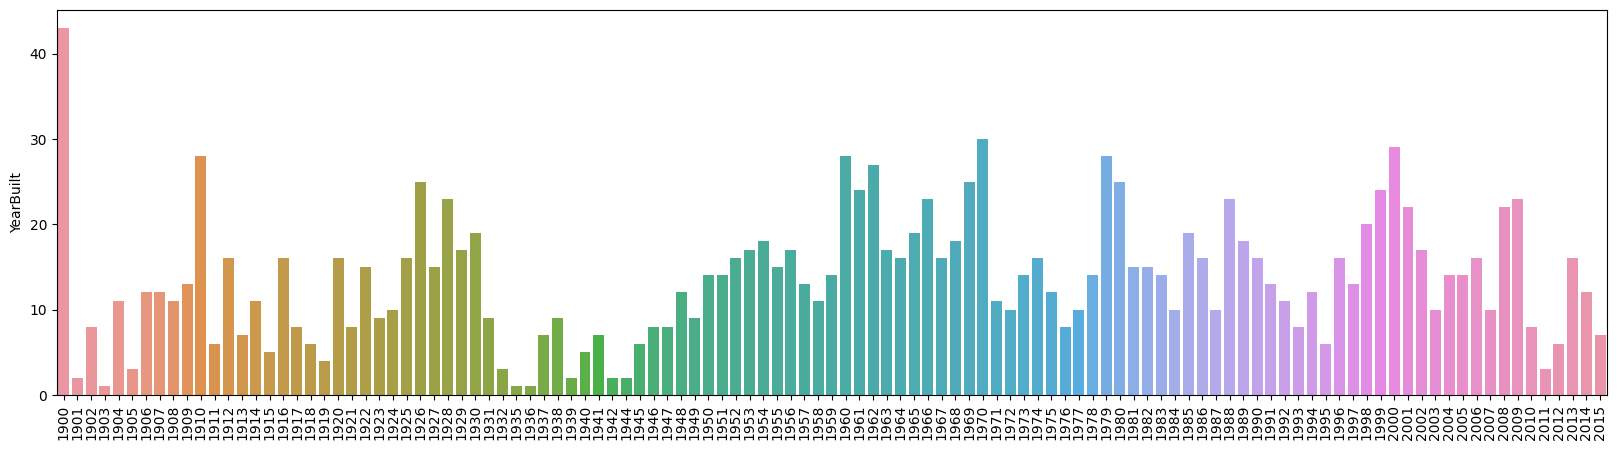

In [34]:
# Année de construction :
Annee = df['YearBuilt'].value_counts().to_frame().reset_index().sort_values('index')

plt.subplots(figsize = (20,5))
sns.barplot(x = Annee['index'], y = Annee['YearBuilt'])
plt.xticks(rotation = 90)
plt.xlabel("")
plt.show()

- **Les plus vieux batiments datent de 1900.**
- **Pas d'augmentation du nombre de construction en fonction des années.**
- **Supposition : tous les batiments avant 1900 sont mis dans la colonne 1900 car c'est l'année avec le plus de construction.**
- **Sur internet** : 1851 > Fondation de la ville de Seattle. 1910 > Croissance rapide de la ville
- **Faire une discrétisation des années.**

In [35]:
#Discrétisation des années :
def Decenie (value):
    return math.floor(value/10)*10

df.insert(4, "YearBuiltDec", 0, allow_duplicates=False)
df['YearBuiltDec'] = df['YearBuilt'].apply(Decenie)

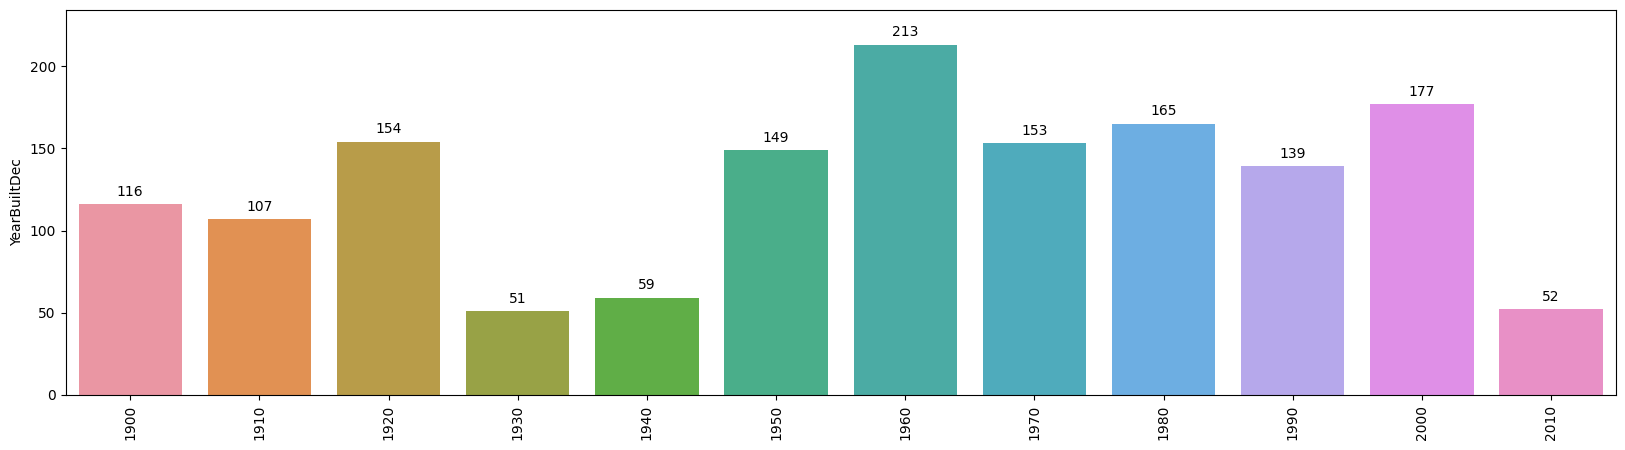

In [36]:
Decenie = df['YearBuiltDec'].value_counts().to_frame().reset_index().sort_values('index')

plt.subplots(figsize = (20,5))
ax = sns.barplot(x = Decenie['index'], y = Decenie['YearBuiltDec'])
ax.bar_label(ax.containers[0], labels = list(Decenie['YearBuiltDec']), padding=4)
plt.xticks(rotation = 90)
plt.xlabel("")
ax.margins(y=0.1)
plt.show()

- **On confirme que la construction des batiments n'est pas evolutive avec les décénies.**

In [37]:
# Répartition des batiments en fonction de la décénie :
colormap = cm.LinearColormap(colors=['red', 'yellow', 'green'], vmin=1900, vmax=2010)

m = folium.Map(location = data.Coordonnees[0], zoom_start=11)

for i in range(len(df)): 
    folium.Circle(
        location = df.Coordonnees[i], 
        radius=10, 
        fill=True,
        color=colormap(df.iloc[i]['YearBuiltDec']),
        fill_opacity=0.2        
    ).add_to(m)
m.add_child(colormap)

- **Les plus vieux batiments sont principalement construit dans le centre ville.**

In [38]:
# Moyenne des années de constructions par quartier ou district :
print(df.groupby('CouncilDistrictCode')['YearBuilt'].mean().round().astype(int).sort_values())
print()
print(df.groupby('Neighborhood')['YearBuilt'].mean().round().astype(int).sort_values())

df['YearBuilt']

CouncilDistrictCode
3    1957
7    1958
2    1960
6    1964
4    1966
1    1971
5    1977
Name: YearBuilt, dtype: int32

Neighborhood
DOWNTOWN                 1947
EAST                     1949
SOUTHWEST                1958
BALLARD                  1961
GREATER DUWAMISH         1961
CENTRAL                  1963
NORTHEAST                1966
MAGNOLIA / QUEEN ANNE    1971
NORTHWEST                1973
NORTH                    1975
DELRIDGE                 1977
LAKE UNION               1977
SOUTHEAST                1979
Name: YearBuilt, dtype: int32


0       1927
1       1996
2       1969
3       1926
4       1980
        ... 
1530    1982
1531    2004
1532    1974
1533    1989
1534    1938
Name: YearBuilt, Length: 1535, dtype: int64

- **Le disctrict avec en moyenne les batiments les plus récents et le 5éme, le plus vieux est le 3éme.**
- **Le quartier avec en moyenne les batiments les plus récents et le quartier de LAKE UNION et SOUTHEAST et le Quartier le plus vieux est Downtown.**

In [39]:
# Nb de batiments par construction : 
df['NumberofBuildings'] = df['NumberofBuildings'].astype(int)
df['NumberofBuildings'].value_counts()

1      1433
0        51
2        13
3        12
5         7
4         4
6         4
14        2
8         2
27        1
11        1
9         1
7         1
23        1
10        1
111       1
Name: NumberofBuildings, dtype: int64

In [40]:
df[df['NumberofBuildings'] == 0].head()

BuildingType          PrimaryPropertyType             Coordonnees  \
58   NonResidential               Medical Office   [47.61244, -122.3214]   
71   NonResidential  Small- and Mid-Sized Office  [47.62391, -122.34837]   
132  NonResidential                    Warehouse  [47.57507, -122.35747]   
157  NonResidential                 Large Office  [47.61757, -122.35122]   
196  NonResidential  Small- and Mid-Sized Office    [47.661, -122.31626]   

     CouncilDistrictCode  YearBuiltDec           Neighborhood  YearBuilt  \
58                     3          1960                   EAST       1965   
71                     7          1980  MAGNOLIA / QUEEN ANNE       1986   
132                    1          1910       GREATER DUWAMISH       1916   
157                    7          1960               DOWNTOWN       1968   
196                    4          1960              NORTHEAST       1961   

     NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
58                   0               3            179014                   0   
71                   0               2             66240                2352   
132                  0               4             79600                   0   
157                  0               3            100734               26731   
196                  0               5             99005                   0   

     PropertyGFABuilding(s)      LargestPropertyUseType  \
58                   179014              Medical Office   
71                    63888                      Office   
132                   79600  Non-Refrigerated Warehouse   
157                   74003                      Office   
196                   99005                      Office   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
58                    179014.0                          NaN   
71                     45900.0                  Data Center   
132                    79600.0                          NaN   
157                   100734.0                          NaN   
196                    79555.0                          NaN   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
58                               NaN                         NaN   
71                            5181.0         Distribution Center   
132                              NaN                         NaN   
157                              NaN                         NaN   
196                              NaN                         NaN   

     ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
58                              NaN             48.0         93.300003   
71                           4551.0              NaN         74.900002   
132                             NaN             34.0         30.299999   
157                             NaN             20.0         97.199997   
196                             NaN             70.0         59.400002   

     SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
58            92.300003          213.399994            210.300003   
71            75.400002          235.199997            236.600006   
132           30.299999           95.099998             95.099998   
157           98.199997          305.100006            308.399994   
196           63.000000          137.600006            140.699997   

     SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
58           16701055.00            16527711.00             0.0   
71            4166306.25             4192107.75             0.0   
132           2411402.25             2411402.25             0.0   
157           9788717.00             9892566.00             0.0   
196           4728488.50             5008123.50             0.0   

     Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
58       2.897563e+06          9886484.0         68145.70313   
71       1.221074e+06          4166305.0             0.00000   
132      7.067

- **Il y a des Batiments avec 0 building de noté mais bien des batiments...**

In [41]:
# Remplacement des building à 0 par la moyenne par quartier/etages/surfaces :
ListIndex = df[df['NumberofBuildings'] == 0].index

dfbuild = df[['Neighborhood','PropertyGFATotal','NumberofBuildings','NumberofFloors']]
dfbuild['PropertyGFATotal'] = dfbuild['PropertyGFATotal'].round(-4)

for index in ListIndex :
    Quartier = df.iloc[index:index+1]['Neighborhood'].values[0]
    Nbetages = df.iloc[index:index+1]['NumberofFloors'].values[0]
    Surface =  df.iloc[index:index+1]['PropertyGFATotal'].values[0].round(-4)
    df['NumberofBuildings'].iloc[index:index+1] = dfbuild.groupby(['Neighborhood','PropertyGFATotal','NumberofFloors'])['NumberofBuildings'].mean().round().astype(int)[Quartier][Surface][Nbetages]

In [42]:
# Remplacement des building à 0 par la moyenne par quartier : 
ListIndex = df[df['NumberofBuildings'] == 0].index
for index in ListIndex :
    Quartier = df.iloc[index:index+1]['Neighborhood'].values[0]
    df['NumberofBuildings'].iloc[index:index+1] = df.groupby('Neighborhood')['NumberofBuildings'].mean().round().astype(int)[Quartier]

In [43]:
# Nb d'étages : 
df['NumberofFloors'].value_counts().head()

1    426
2    352
3    238
4    135
5    101
Name: NumberofFloors, dtype: int64

In [44]:
df[df['NumberofFloors'] == 0].head()

BuildingType PrimaryPropertyType             Coordonnees  \
136  NonResidential               Hotel   [47.61275, -122.3333]   
435  NonResidential      Medical Office  [47.60979, -122.32298]   
436  NonResidential  Mixed Use Property  [47.61783, -122.33729]   
508  NonResidential               Other  [47.61289, -122.33531]   
991  NonResidential      Medical Office  [47.60862, -122.32372]   

     CouncilDistrictCode  YearBuiltDec Neighborhood  YearBuilt  \
136                    7          1990     DOWNTOWN       1999   
435                    3          2000         EAST       2004   
436                    7          2000     DOWNTOWN       2006   
508                    7          1990     DOWNTOWN       1999   
991                    3          1940         EAST       1945   

     NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
136                  1               0            934292                   0   
435                  1               0            225982                   0   
436                  1               0            516407                   0   
508                  1               0            947987                   0   
991                  1               0            274568                   0   

     PropertyGFABuilding(s) LargestPropertyUseType  LargestPropertyUseTypeGFA  \
136                  934292                  Hotel                   495536.0   
435                  225982         Medical Office                   200184.0   
436                  516407                Parking                   385196.0   
508                  947987           Other - Mall                   561684.0   
991                  274568         Medical Office                   228133.0   

              SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
136                                Parking                         438756.0   
435                                    NaN                              NaN   
436                    Multifamily Housing                         340236.0   
508  Other - Entertainment/Public Assembly                         100000.0   
991                                Parking                         135954.0   

    ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
136                  Restaurant                         49700.0   
435                         NaN                             NaN   
436                       Hotel                         67627.0   
508                  Restaurant                         80000.0   
991                         NaN                             NaN   

     ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
136              NaN        117.900002          120.500000   
435             53.0        102.699997          103.699997   
436             31.0         76.300003           78.900002   
508              NaN         62.299999           62.099998   
991             52.0        111.000000          111.199997   

     SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
136          272.899994            278.200012           65047284.0   
435          246.899994            245.300003           20560622.0   
436          199.199997            202.000000           39403320.0   
508          195.600006            194.899994           46510960.0   
991          235.500000            233.100006           25311526.0   

     SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
136             66502836.0             0.0       11536962.00   
435             20764814.0       7815663.0        3735333.25   
436             40754364.0             0.0        8626261.00   
508             46343304.0             0.0       13631581.00   
991             25358122.0      13296249.0        3521475.75   

     Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
136         39364114.0        256831.62500        25683162.0   
435         12744957.0             0.00000            

- **Il y a des batiments dont des hotels avec 0 étages c'est impossible.**
- **Intéressant si on suppose que plus le batiment est haut plus il risque de consommer???.**

In [45]:
# Remplacement des etages à 0 par la moyenne par quartier/batiments/surfaces :
ListIndex = df[df['NumberofFloors'] == 0].index

dfbuild = df[['Neighborhood','PropertyGFATotal','NumberofBuildings','NumberofFloors']]
dfbuild['PropertyGFATotal'] = dfbuild['PropertyGFATotal'].round(-4)

for index in ListIndex :
    Quartier = df.iloc[index:index+1]['Neighborhood'].values[0]
    Nbbuildings = df.iloc[index:index+1]['NumberofBuildings'].values[0]
    Surface =  df.iloc[index:index+1]['PropertyGFATotal'].values[0].round(-4)
    df['NumberofFloors'].iloc[index:index+1] = dfbuild.groupby(['Neighborhood','PropertyGFATotal','NumberofBuildings'])['NumberofFloors'].mean().round().astype(int)[Quartier][Surface][Nbbuildings]

In [46]:
# Remplacement des floors à 0 par la moyenne par quartier :
ListIndex = df[df['NumberofFloors'] == 0].index
for index in ListIndex :
    Quartier = df.iloc[index:index+1]['Neighborhood'].values[0]
    df['NumberofFloors'].iloc[index:index+1] = df.groupby('Neighborhood')['NumberofFloors'].mean().round().astype(int)[Quartier]

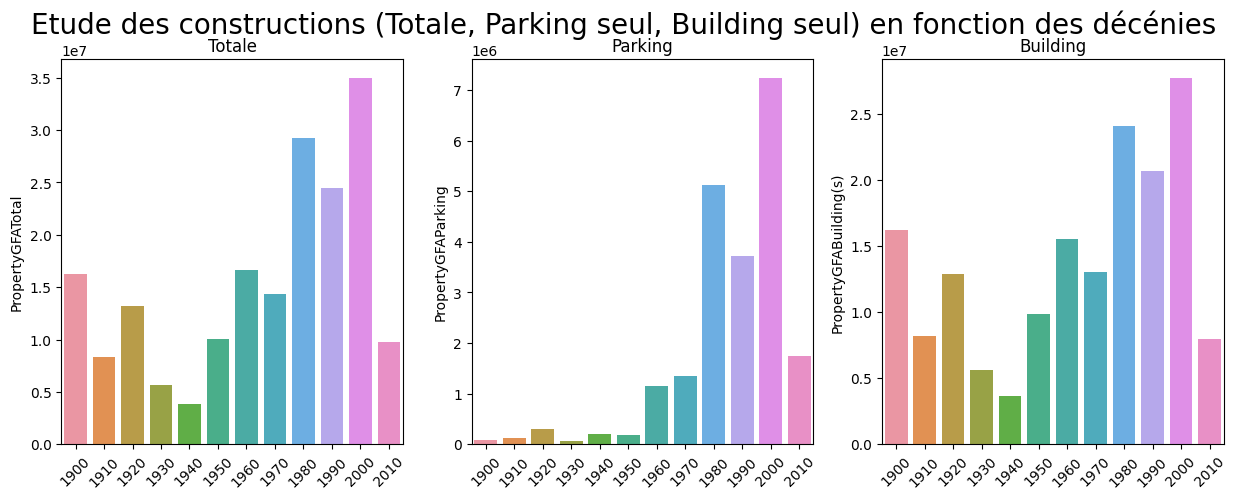

In [47]:
# Surface :
df['PropertyGFATotal'].unique()
df['PropertyGFAParking'].unique()
df['PropertyGFABuilding(s)'].unique()

Surface2 = df.groupby('YearBuiltDec')[['PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)']].sum().reset_index()

fig, ax = plt.subplots(ncols = 3, figsize = (15,5))
plt.suptitle('Etude des constructions (Totale, Parking seul, Building seul) en fonction des décénies', size = 20)

ax1 = plt.subplot(131)
ax1 = sns.barplot(x = Surface2['YearBuiltDec'], y = Surface2['PropertyGFATotal'])
plt.xticks(rotation = 45)
plt.xlabel('')
plt.title('Totale')

ax2 = plt.subplot(132)
ax2 = sns.barplot(x = Surface2['YearBuiltDec'], y = Surface2['PropertyGFAParking'])
plt.xticks(rotation = 45)
plt.xlabel('')
plt.title('Parking')

ax3 = plt.subplot(133)
ax3 = sns.barplot(x = Surface2['YearBuiltDec'], y = Surface2['PropertyGFABuilding(s)'])
plt.xticks(rotation = 45)
plt.xlabel('')
plt.title('Building')
plt.show()


- **Variables intéressantes pour la consomation d'énergie surtout celle sans les parking.**
- **Augmentation sur les 40 dernères années (2010 s'arretant à 2015), surtout visible sur les parkings.**

In [48]:
colormap = cm.LinearColormap(colors=['green','yellow','red'], vmin=df['PropertyGFABuilding(s)'].min(), vmax=df['PropertyGFABuilding(s)'].max())

m = folium.Map(location = df.Coordonnees[0], zoom_start=11)

for i in range(len(df)): 
    folium.Circle(
        location = df.Coordonnees[i], 
        radius=(df.iloc[i]['PropertyGFABuilding(s)'])/10000, 
        fill=True,
        color=colormap(df.iloc[i]['PropertyGFABuilding(s)']),
        fill_opacity=0.2,
    ).add_to(m)
m.add_child(colormap)

- **Grosse surface de building dans le centre ville.**

In [49]:
# Suppression de la colonne Coordonnées pour ne garder que les quartiers et les districts :
del df['Coordonnees']

In [50]:
# EnergyStarScore : 
print(df['ENERGYSTARScore'].unique())
print(df['ENERGYSTARScore'].isna().mean())

[ 60.  61.  43.  56.  75.  nan  27.  30.  36.  48.  58.  35.  31.  39.
  76.  84.  57.  29.   8.  97.  83.  95.  67.  78.  14.  71.  63.  98.
  99.  86.  80.  81.  94.  54.   1.  74.  96.  37.  91.  93.  68.  53.
  34. 100.  89.  92.  21.  10.  72.  87.  79.  70.  64.  49.  62.  46.
  42.  20.  90.  85.  66.  69.  28.  77.  88.  65.   3.  45.   2.  55.
  25.   6.  59.  19.   7.   5.  23.  38.  73.  33.  26.  41.  32.  82.
  15.  16.  50.  12.  51.  13.  11.  47.  18.  24.  17.  52.  44.   4.
  40.  22.   9.]
0.36351791530944627


- **Vide à 36%**
- Une EPA a calculé une note de 1 à 100 qui évalue la performance énergétique globale d'une propriété, sur la base de données nationales pour contrôler les différences entre le climat, les utilisations des bâtiments et les opérations. Un score de 50 représente la médiane nationale.
- **Variable intéressante mais comment est elle calculée???, (voir le site spécifique)**
- **Variable pour comparaison de notre propre modéle.**

# 6 : Etude des variables quantitatives de consommations

In [51]:
# Etude des données de consommation :
Consommation = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
    'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

df[Consommation].describe()

SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
count       1535.000000         1534.000000         1535.000000   
mean          74.838827           77.253716          182.780586   
std           75.687773           76.726574          189.121265   
min            0.000000            0.000000            0.000000   
25%           34.650000           36.649999           79.599998   
50%           53.500000           56.099998          138.600006   
75%           85.299999           87.900002          213.699997   
max          834.400024          834.400024         2620.000000   

       SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
count           1535.000000         1.535000e+03           1.534000e+03   
mean             184.861954         8.875487e+06           8.450568e+06   
std              189.174263         3.143793e+07           2.287352e+07   
min               -2.100000         0.000000e+00           0.000000e+00   
25%               82.000000         1.222025e+06           1.293946e+06   
50%              141.600006         2.688676e+06           2.796739e+06   
75%              215.750000         7.320690e+06           7.516609e+06   
max             2620.000000         8.739237e+08           4.716139e+08   

       SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  \
count    1.535000e+03      1.535000e+03       1.535000e+03   
mean     5.525957e+05      1.806327e+06       6.163189e+06   
std      5.742024e+06      6.330376e+06       2.159924e+07   
min      0.000000e+00     -3.382680e+04      -1.154170e+05   
25%      0.000000e+00      2.134793e+05       7.283915e+05   
50%      0.000000e+00      5.032622e+05       1.717131e+06   
75%      0.000000e+00      1.543201e+06       5.265402e+06   
max      1.349435e+08      1.925775e+08       6.570744e+08   

       NaturalGas(therms)  NaturalGas(kBtu)  TotalGHGEmissions  \
count        1.535000e+03      1.535000e+03        1535.000000   
mean         2.045226e+04      2.045226e+06         194.241739   
std          9.750866e+04      9.750866e+06         782.321600   
min          0.000000e+00      0.000000e+00          -0.800000   
25%          0.000000e+00      0.000000e+00          20.150000   
50%          4.749870e+03      4.749870e+05          49.580000   
75%          1.531622e+04      1.531622e+06         147.315000   
max          2.979090e+06      2.979090e+08       16870.980000   

       GHGEmissionsIntensity  
count            1535.000000  
mean                1.662404  
std                 2.415777  
min                -0.020000  
25%                 0.350000  
50%                 0.880000  
75%                 1.950000  
max                34.090000

- **Il y a des valeurs à 0 et négatives.**
- **Les valeurs à 0 pour Steam et Gaz sont plutot logique mais pour les autres variables c'est peu normal.**

In [52]:
# Suppression des lignes avec des valeurs négatives :
df = df[df['SourceEUIWN(kBtu/sf)'] >= 0].reset_index(drop = True)

# Il y a des 0 dans electricité :
print(df[df['Electricity(kBtu)'] == 0]['PrimaryPropertyType'])
df = df[df['Electricity(kBtu)'] != 0]

print()

print(df[df['SourceEUI(kBtu/sf)'] == 0]['PrimaryPropertyType'])
df = df[df['SourceEUI(kBtu/sf)'] != 0].reset_index(drop = True)

112                     K-12 School
117                     K-12 School
377                      Restaurant
458     Supermarket / Grocery Store
1026                    K-12 School
1465                    K-12 School
Name: PrimaryPropertyType, dtype: object

27             K-12 School
57             K-12 School
76             K-12 School
80             K-12 School
86             K-12 School
557            K-12 School
573            K-12 School
1356    Mixed Use Property
Name: PrimaryPropertyType, dtype: object


- **Il semblerait que les écoles n'utilisent pas d'éléctricité.**

In [53]:
df[Consommation].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SiteEUI(kBtu/sf)       1520 non-null   float64
 1   SiteEUIWN(kBtu/sf)     1519 non-null   float64
 2   SourceEUI(kBtu/sf)     1520 non-null   float64
 3   SourceEUIWN(kBtu/sf)   1520 non-null   float64
 4   SiteEnergyUse(kBtu)    1520 non-null   float64
 5   SiteEnergyUseWN(kBtu)  1519 non-null   float64
 6   SteamUse(kBtu)         1520 non-null   float64
 7   Electricity(kWh)       1520 non-null   float64
 8   Electricity(kBtu)      1520 non-null   float64
 9   NaturalGas(therms)     1520 non-null   float64
 10  NaturalGas(kBtu)       1520 non-null   float64
 11  TotalGHGEmissions      1520 non-null   float64
 12  GHGEmissionsIntensity  1520 non-null   float64
dtypes: float64(13)
memory usage: 154.5 KB


- **Il reste des NaNs dans certaines colonnes.**

Pour la colonne SiteEUI(kBtu/sf), et la colonne SiteEUIWN(kBtu/sf) : Intercept = 1.96 Slope = 1.01 R² = 1.0
Pour la colonne SourceEUI(kBtu/sf), et la colonne SourceEUIWN(kBtu/sf) : Intercept = 3.24 Slope = 0.99 R² = 1.0
Pour la colonne SiteEnergyUse(kBtu), et la colonne SiteEnergyUseWN(kBtu) : Intercept = 3945933.14 Slope = 0.51 R² = 1.0
Pour la colonne Electricity(kWh), et la colonne Electricity(kBtu) : Intercept = 0.0 Slope = 3.41 R² = 1.0
Pour la colonne NaturalGas(therms), et la colonne NaturalGas(therms) : Intercept = 0.0 Slope = 1.0 R² = 1.0


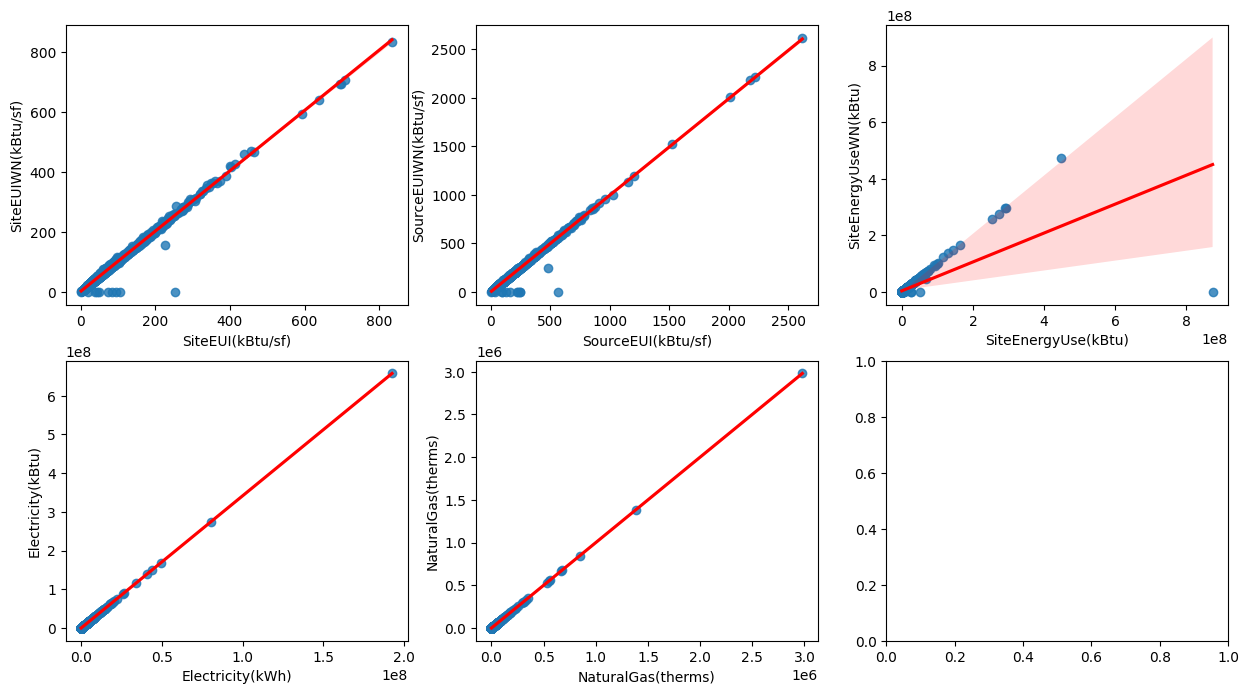

In [54]:
# Analyse par paire de colonne du même genre :
ColonneX = ['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','Electricity(kWh)','NaturalGas(therms)']
ColonneY = ['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kBtu)', 'NaturalGas(therms)']
zone = [231,232,233,234,235]

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15,8))
for X, Y, Z in zip(ColonneX, ColonneY, zone):
    plt.subplot(Z)
    p = sns.regplot(df, x = X, y = Y, line_kws={"color": "red"})
    slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(), y=p.get_lines()[0].get_ydata())
    print('Pour la colonne {}, et la colonne {} :'.format(X, Y), 'Intercept =', round(intercept,2), 'Slope =', round(slope,2), 'R² =', round(r,4))
plt.show()

- **On remarque toujours une corrélation logique entre les deux types de colonnes qui sont soit dans une unité différente soit normalisées par des valeurs météorologique.**
- **On remarque cependant des 0 pour les 3 premiers groupes de variables. Ces 0 n'ont rien à faire la et sont surement due à une erreure de normalisation.**

In [55]:
# Analyse sur un couple de variable :
df[(df['SiteEUIWN(kBtu/sf)'] == 0) & (df['SiteEUI(kBtu/sf)'] != 0)][['SiteEUIWN(kBtu/sf)','SiteEUI(kBtu/sf)']]

SiteEUIWN(kBtu/sf)  SiteEUI(kBtu/sf)
169                  0.0        105.199997
195                  0.0         73.000000
231                  0.0         43.400002
296                  0.0         50.000000
644                  0.0         20.700001
659                  0.0         37.599998
1486                 0.0         93.800003
1487                 0.0         85.099998
1488                 0.0        252.000000

- **On a bien les valeurs non normalisées mais des valeurs normalisés à 0.**
- **Cherchons à modifier ces valeurs.**

In [56]:
# Compléter les NaNs et les 0 des colonnes en WN :

# Modification des valeurs à 0:
for X, Y in zip(ColonneX[:3], ColonneY[:3]):

    # Remplassement des 0 par des nans.
    Index = df[(df[Y] == 0) & (df[X] != 0)][Y].index

    for i in Index:
        df[Y].iloc[i:i+1] = np.nan

    # Prédiction des valeurs manquantes
    da = df[df[Y].notna()]
    x = da[X]
    y = da[Y]
    model = np.polyfit(x, y, deg = 1)
    predict = np.poly1d(model)

    # Récupération des index des lignes vides:
    Index = df[df[Y].isna()].index

    # Remplir les valeurs manquantes :
    for i in Index:
        df[Y].iloc[i:i+1] = predict(df.iloc[i:i+1][X].values[0])

- **Il y a un restaurant et un supermarché à 0 en electricité ce n'est pas possible.**

In [57]:
# Suppression des colonnes en trop pour ne garder que les colonnes dans la même unité : 
df = df.drop(columns = ['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)'])

- **J'ai gardé les colonnes normalisées par les données météorologiques et tous dans la même unité.**

In [58]:
# Transformation des autres colonnes énergétiques pour qu'elles soient vs surface :
Consommation = ['SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)','NaturalGas(kBtu)']

for Conso in Consommation:
    df[Conso] = df[Conso]/df['PropertyGFATotal']

# Rennomage des colonnes :
df.rename(columns = {'SiteEnergyUseWN(kBtu)' : 'SiteEnergyUseWN(kBtu/sf)', 'SteamUse(kBtu)' : 'SteamUse(kBtu/sf)', 'Electricity(kBtu)' : 'Electricity(kBtu/sf)','NaturalGas(kBtu)': 'NaturalGas(kBtu/sf)'}, inplace = True)

In [59]:
# Etude du SteamUse :
Steam0 = df['SteamUse(kBtu/sf)'].value_counts().head(1).values[0]
print(Steam0)
print(Steam0/len(df)*100)

1409
92.69736842105263


- **1429 construction sont à 0 pour cette variable soit 92% de la DF.**

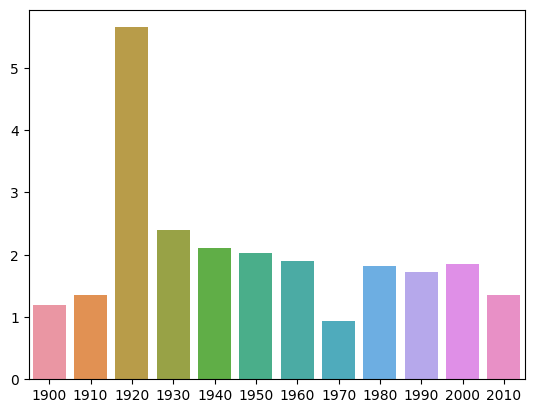

In [60]:
# Consommation de vapeur ??? est elle plus utilisée dans les vieux batiments.
Graph6 = df.groupby('YearBuiltDec')['SteamUse(kBtu/sf)'].mean()
sns.barplot(x = Graph6.index, y = Graph6.values)
plt.xlabel('')
plt.show()

- **Gros pic dans les années 20 mais plutot constant depuis sauf dans les années 1970.**

In [61]:
# Etude du GHGE emissions et intensity:
print(list(df[df['GHGEmissionsIntensity'] == 0]['PrimaryPropertyType']))

del df['TotalGHGEmissions']

[]


- **Aprés vérification la colonne intensity est bien la division de l'Emission divisé par la totalité de la surface des batiments de la construction**

# 7 : Recentrage et choix de la colonne cumullèe

**Definitions :**
- **Données cumullées :**
    - **SiteEUI**  : L'intensité de consommation d'énergie du site (IUE) est la consommation d'énergie du site d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie du site est le montant annuel de toute l'énergie consommée par la propriété sur le site, tel qu'indiqué sur les factures de services publics. L'IE du site est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré..
    - **SourceEUI** : L'intensité de consommation d'énergie à la source (IUE) est la consommation d'énergie à la source d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie à la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes de production, de transmission et de distribution. Source EUI est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.
    - **SiteEnergyEUI**  : La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie.
- **Données de consommations :**
    - **SteamUse(kBtu)** : La quantité annuelle de vapeur de quartier consommée par la propriété sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).
    - **Electricity(kBtu)** : La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes renouvelables sur place, mesurée en kWh.
    - **NaturalGas(kBtu)** : La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en milliers d'unités thermiques britanniques (kBtu).
    - **GHGEmissionsIntensity** : Émissions totales de gaz à effet de serre divisées par la surface de plancher brute de la propriété, mesurée en kilogrammes d'équivalent en dioxyde de carbone par pied carré. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light.

In [62]:
df[['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu/sf)']]

SiteEUIWN(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu/sf)
0              84.300003            189.000000                 84.321754
1              97.900002            179.399994                 83.661424
2              97.699997            244.100006                 77.331177
3             113.300003            224.000000                113.287679
4             118.699997            215.600006                 83.474786
...                  ...                   ...                       ...
1515           56.200001            136.600006                 56.154215
1516           65.900002            118.900002                 65.856609
1517          460.100006            767.799988                460.117390
1518           55.500000            110.800003                 55.516723
1519           70.900002            123.900002                 70.857836

[1520 rows x 3 columns]

- **En divisant le Site EnergyUse par la surface on retombe bien sur le SiteEUI, la 1ére colonne ne sert donc à rien.**

In [63]:
# Suppression des colonnes inutiles:
del df['SiteEnergyUseWN(kBtu/sf)']
del df['SourceEUIWN(kBtu/sf)']

# 8 : Etude des outliers

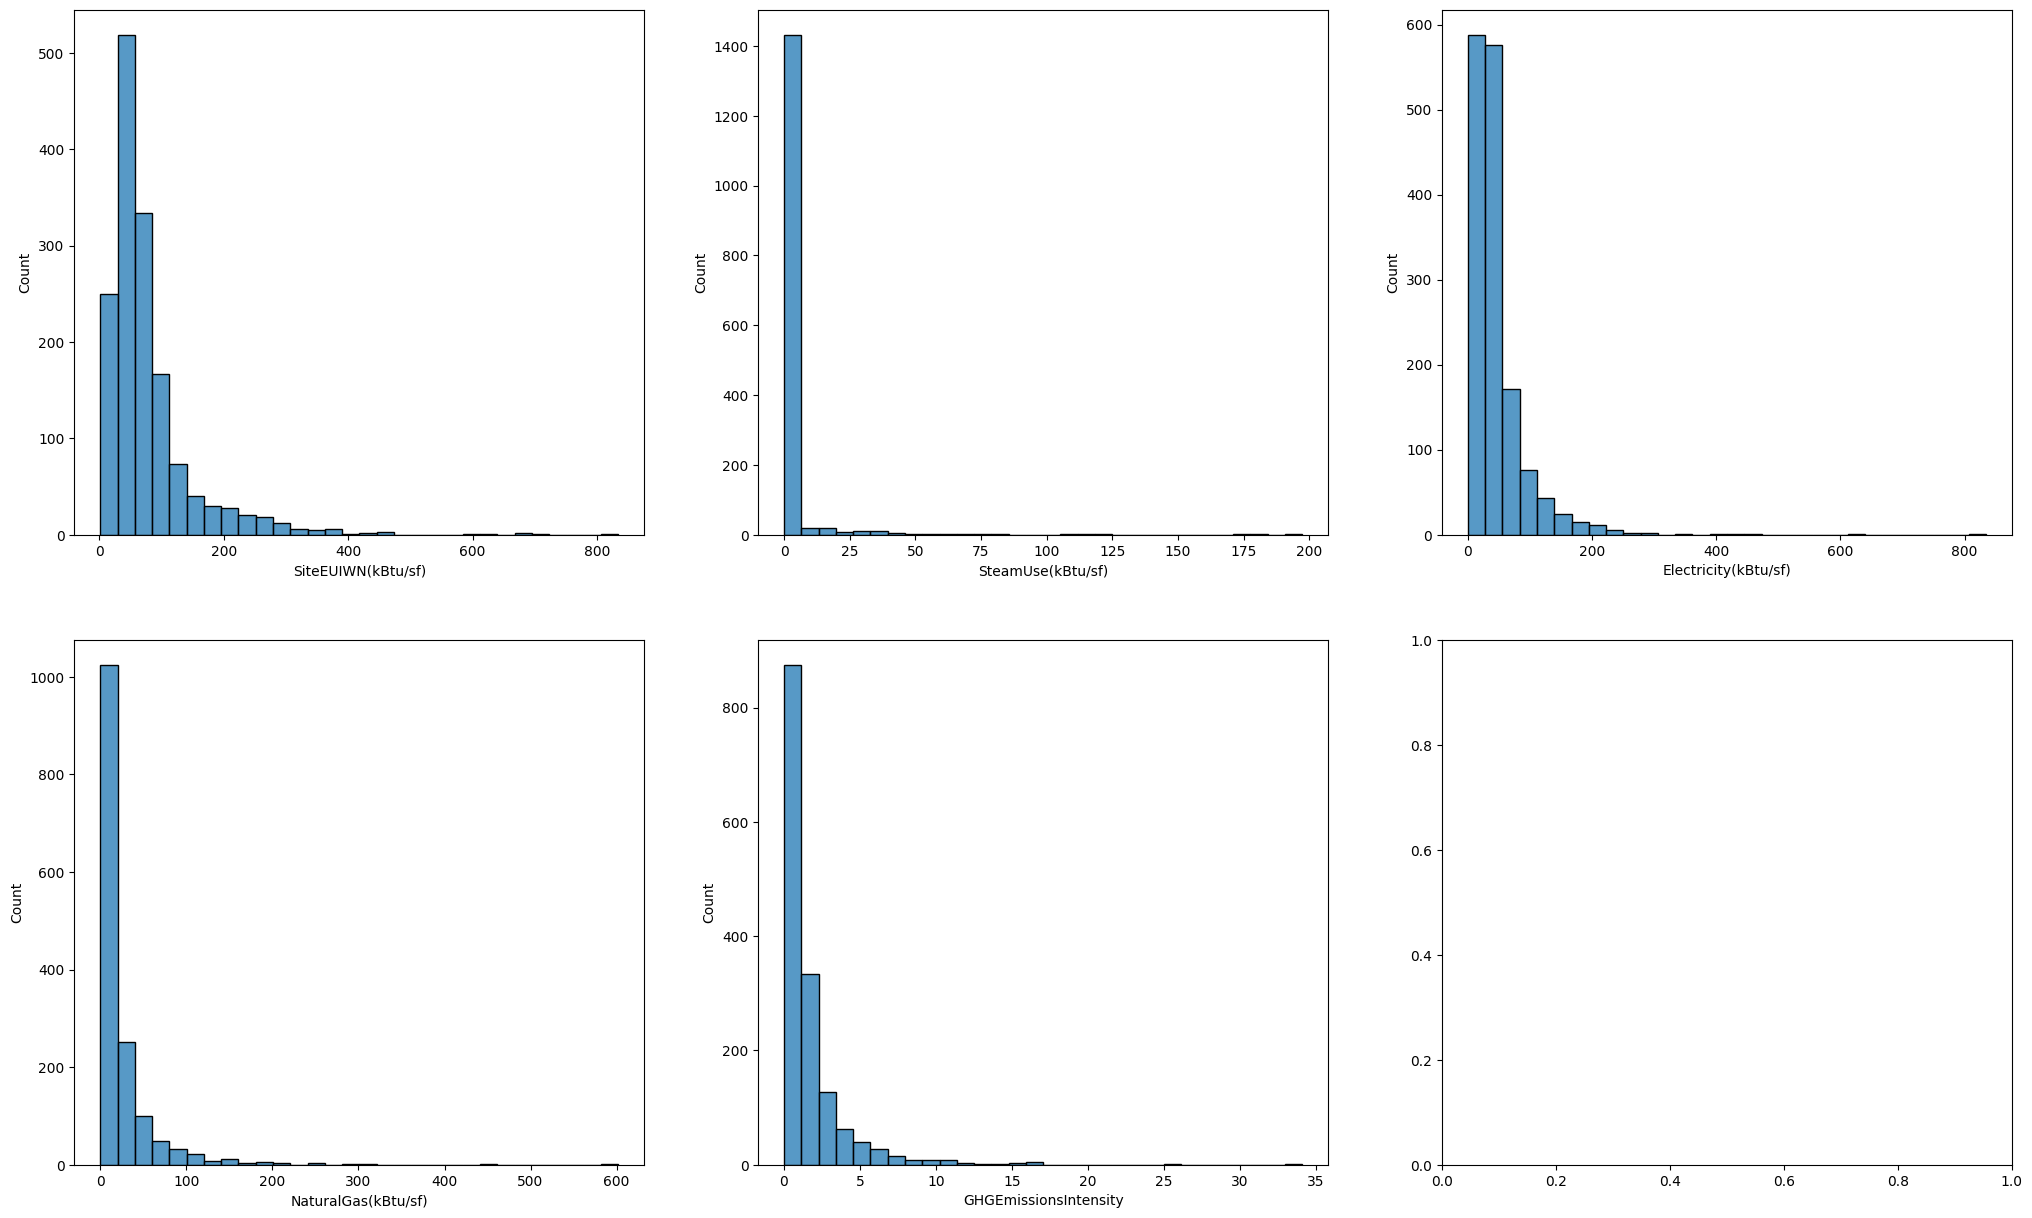

In [64]:
# Etude des outliers:
Consommation = ['SiteEUIWN(kBtu/sf)', 'SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)','NaturalGas(kBtu/sf)','GHGEmissionsIntensity']
zone = [231,232,233,234,235]

plt.subplots(figsize = (25,15), ncols = 3, nrows = 2)
for Variable, Z in zip(Consommation,zone) :
    plt.subplot(Z)
    sns.histplot(df[Variable], bins = 30)
plt.show()

In [65]:
# Suppression des outliers dans les targets :
Targets = ['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity']
#df = df[df['SiteEUIWN(kBtu/sf)'] < 400]

In [66]:
def find_outliers_IQR(df,alpha):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[df>(q3+alpha*IQR)]

    return outliers.index


def outliers(colonne):
    GoodAlpha = 0
    NewGoodAlpha = -1
    Alpha = 0
    NbStep = 0

    Outliers = []


    for i in range (5,100,1) :
        outliers = find_outliers_IQR(df[colonne], i/5)
        NewGoodAlpha = round(len(outliers)/len(df)*100,1)
        if GoodAlpha != NewGoodAlpha :
            GoodAlpha = NewGoodAlpha
        else :
            NbStep += 1
            if NbStep != 2:
                continue
            else:
                outliers = find_outliers_IQR(df[colonne], i/5)
                print(colonne,len(outliers))
                for outlier in outliers:
                    Outliers.append(outlier)

    return list(set(Outliers))

In [67]:
# Suppression de ces outliers :
Consommation = ['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity']

for colonne in Consommation :
    index = outliers(colonne)
    df = df.drop(index = index).reset_index(drop = True)

SiteEUIWN(kBtu/sf) 12
GHGEmissionsIntensity 16


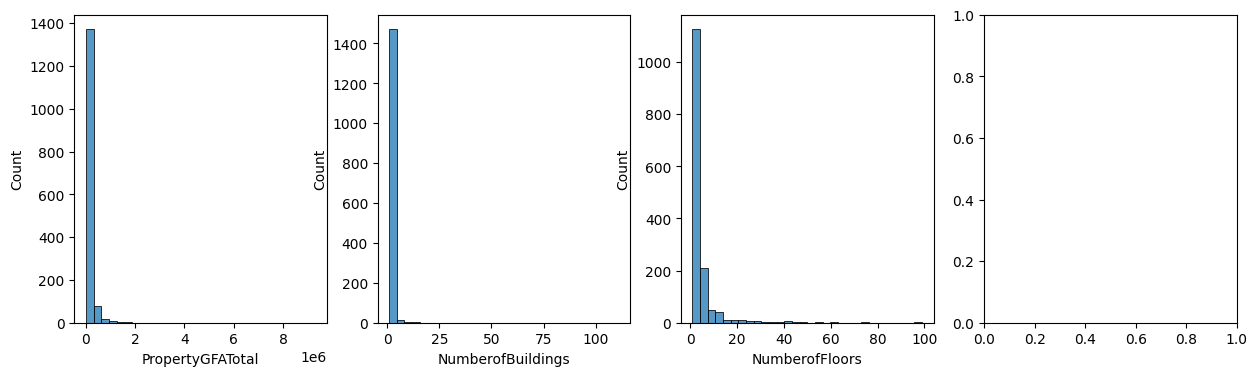

In [68]:
# Etude des outliers:
Consommation = ['PropertyGFATotal', 'NumberofBuildings','NumberofFloors']
zone = [141,142,143,144]

plt.subplots(figsize = (15,4), ncols = 4, nrows = 1)
for Variable, Z in zip(Consommation,zone) :
    plt.subplot(Z)
    sns.histplot(df[Variable], bins = 30)
plt.show()

# 9 : Suppression des variables inutiles et transformation de certaines

In [69]:
# Analyse des surfaces des batiments 1 , 2  et 3 vs total : 
Surf = (df['PropertyGFATotal'] - df[['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']].sum(axis = 1)).to_frame()
Surf[Surf[0] < 0]

0
4    -15874.000000
10    -3464.000000
12   -37159.000000
13     -400.000000
14    -2987.000000
...            ...
1473  -6373.000000
1474 -14632.200195
1475  -2873.000000
1479   -728.000000
1481   -844.000000

[360 rows x 1 columns]

- **IL y a des problème sur les surfaces si on compare à la surface total, 360 batiments ont plus de surface sur le cumul des 3 plus gros batiments que sur la surface totale...**

In [71]:
# Liste des batiments :
dfBatiments = pd.concat([df['LargestPropertyUseType'],df['SecondLargestPropertyUseType']])
dfBatiments = pd.concat([dfBatiments, df['ThirdLargestPropertyUseType']])
ListBatiments = dfBatiments.to_frame().value_counts()
ListBatiments = list(ListBatiments.index)
Batiments = []
for b in ListBatiments:
    Batiments.append(b[0])

V1 = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
V2 = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']

for b in Batiments :
    df[b + ' (%)'] = 0

for i in range(len(df)):
    for var1, var2 in zip (V1,V2):
        if df[var1].iloc[i:i+1].values[0] in Batiments :
            Colonne = df[var1].iloc[i:i+1].values[0]
            Valeur = df[var2].iloc[i:i+1].values[0]
            df[Colonne + ' (%)'].iloc[i:i+1] = Valeur
        else :
            pass

df['Parking'+ ' (%)'] = df['PropertyGFAParking']
# df['AutresBatiments'] = ((df['PropertyGFATotal'] - df[Batiments].sum(axis = 1))/df['PropertyGFATotal']*100).astype(int)

for b in Batiments :
    df[b + ' (%)'] = (df[b + ' (%)']/df['PropertyGFATotal']*100).round(2)

In [72]:
# Surfaces globales par types de batiments :
VariablesBat = df.iloc[:,23:].columns
print(df[VariablesBat].sum().sort_values(ascending = False).describe())

dfchoix = df[VariablesBat].sum().sort_values(ascending = False).to_frame()
Cinquante = dfchoix[0].quantile(0.50) # Pour somme des 50% des variables les plus basses.
L = list(dfchoix[dfchoix[0] < Cinquante].index)
df['Other (%)'] = df['Other (%)'] + df[L].sum(axis = 1)
df.drop(columns = L, inplace = True)

count       64.000000
mean      2355.794688
std       6045.597625
min          0.000000
25%        131.417500
50%        366.070000
75%       1553.055000
max      42355.070000
dtype: float64


- **Toutes les piscines sont à 0 en surface.**

In [73]:
# Suppression des variables 3 propriétés les plus larges :
del df['LargestPropertyUseType']
del df['LargestPropertyUseTypeGFA']
del df['SecondLargestPropertyUseType']
del df['SecondLargestPropertyUseTypeGFA']
del df['ThirdLargestPropertyUseType']
del df['ThirdLargestPropertyUseTypeGFA']

# Suppression de la variable parking qui est du coup en double :
del df['PropertyGFAParking']

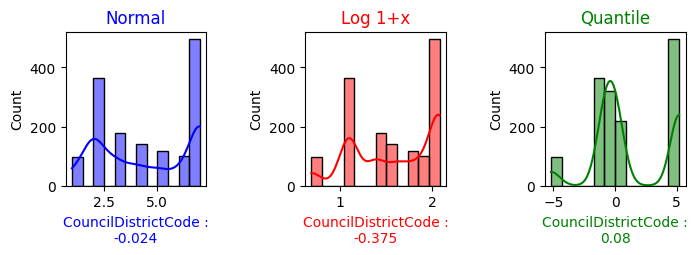

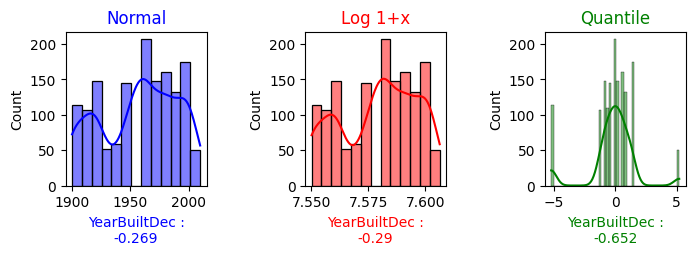

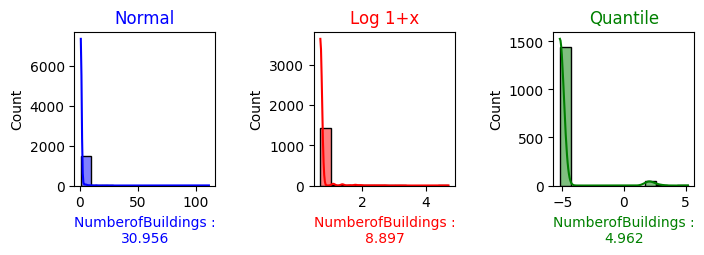

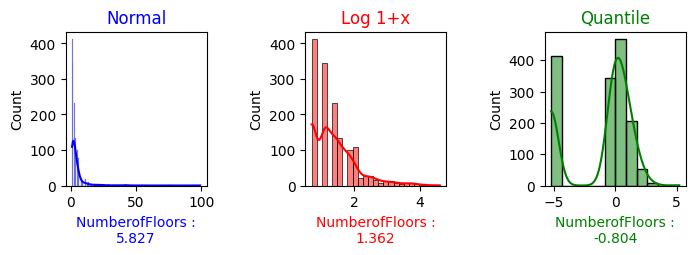

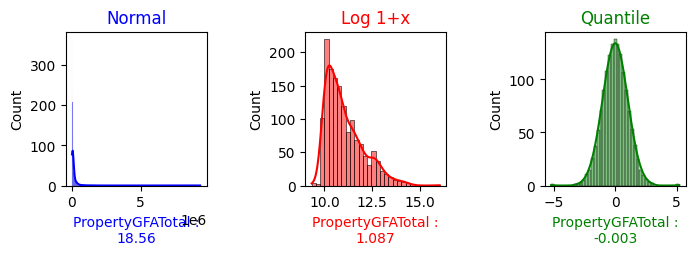

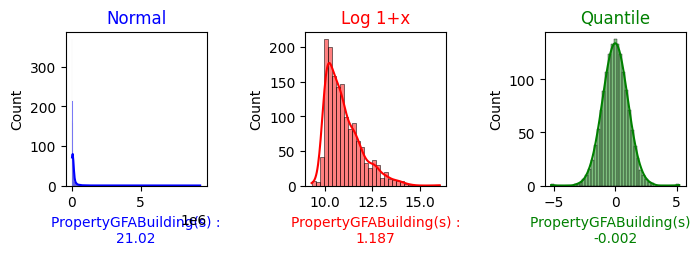

In [74]:
# Etude de l'assymétrie des données :
from scipy.stats import skew
import colorama
from sklearn.preprocessing import QuantileTransformer
Colonnes = ['CouncilDistrictCode', 'YearBuiltDec', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)']

for colonne in Colonnes :
    fig, ax = plt.subplots(1, 3, figsize = (8,2))
    plt.subplot(131)
    sns.histplot(df[colonne], color="blue", kde=True)
    plt.title('Normal', color = 'blue')
    plt.xlabel(colonne + ' :' + "\n" + str(round(skew(df[colonne].to_list()),3)), color = 'blue')
    plt.subplot(132)
    sns.histplot(np.log(1 + df[colonne]), color="red", kde=True)
    plt.title('Log 1+x', color = 'Red')
    plt.xlabel(colonne + ' :' + "\n" + str(round(skew(np.log(1 + df[colonne]).to_list()),3)), color = 'Red')
    plt.subplot(133)
    QT = pd.DataFrame(QuantileTransformer(output_distribution="normal").fit_transform(df[colonne].to_frame())).rename(columns = {0 : colonne})[colonne]
    sns.histplot(QT , color="green", kde=True,)
    plt.title("Quantile", color = 'green')
    plt.xlabel(colonne + ' :' + "\n" + str(round(skew(QT.to_list()),3)), color = 'green')
    plt.subplots_adjust(wspace = 0.7)
    plt.show()

In [75]:
# Transformation log:

Variables = ['PropertyGFATotal', 'PropertyGFABuilding(s)']

for var in Variables :
    df[var] = np.log(1 + df[var])

# 10 : Exportation du fichier

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 48 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   BuildingType                                         1492 non-null   object 
 1   PrimaryPropertyType                                  1492 non-null   object 
 2   CouncilDistrictCode                                  1492 non-null   int64  
 3   YearBuiltDec                                         1492 non-null   int64  
 4   Neighborhood                                         1492 non-null   object 
 5   YearBuilt                                            1492 non-null   int64  
 6   NumberofBuildings                                    1492 non-null   int32  
 7   NumberofFloors                                       1492 non-null   int64  
 8   PropertyGFATotal                                     1492 non-null  

- **IL reste donc 1492 constructions.**

In [77]:
df.head()

BuildingType PrimaryPropertyType  CouncilDistrictCode  YearBuiltDec  \
0  NonResidential               Hotel                    7          1920   
1  NonResidential               Hotel                    7          1990   
2  NonResidential               Hotel                    7          1960   
3  NonResidential               Hotel                    7          1920   
4  NonResidential               Hotel                    7          1980   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1              12   
1     DOWNTOWN       1996                  1              11   
2     DOWNTOWN       1969                  1              41   
3     DOWNTOWN       1926                  1              10   
4     DOWNTOWN       1980                  1              18   

   PropertyGFATotal  PropertyGFABuilding(s)  ENERGYSTARScore  \
0         11.390023               11.390023             60.0   
1         11.547974               11.390792             61.0   
2         13.770629               13.540275             43.0   
3         11.023878               11.023878             56.0   
4         12.075856               11.640272             75.0   

   SiteEUIWN(kBtu/sf)  SteamUse(kBtu/sf)  Electricity(kBtu/sf)  \
0           84.300003          22.659633             44.621152   
1           97.900002           0.000000             31.311927   
2           97.699997          22.556561             51.800174   
3          113.300003          36.112953             45.155316   
4          118.699997           0.000000             30.576415   

   NaturalGas(kBtu/sf)  GHGEmissionsIntensity  Office (%)  Parking (%)  \
0            14.433962                   2.83         0.0         0.00   
1            49.679258                   2.86         0.0        14.55   
2             1.562373                   2.19         0.0        20.57   
3            29.537068                   4.67         0.0         0.00   
4            50.142374                   2.88         0.0        35.31   

   Non-Refrigerated Warehouse (%)  Retail Store (%)  Other (%)  Hotel (%)  \
0                             0.0               0.0        0.0     100.00   
1                             0.0               0.0        0.0      80.99   
2                             0.0               0.0        0.0      79.12   
3                             0.0               0.0        0.0     100.00   
4                             0.0               0.0        0.0      70.31   

   Worship Facility (%)  Restaurant (%)  Distribution Center (%)  \
0                   0.0            0.00                      0.0   
1                   0.0            4.46                      0.0   
2                   0.0            0.00                      0.0   
3                   0.0            0.00                      0.0   
4                   0.0            0.00                      0.0   

   Medical Office (%)  K-12 School (%)  Supermarket/Grocery Store (%)  \
0                 0.0              0.0                            0.0   
1                 0.0              0.0                            0.0   
2                 0.0              0.0                            0.0   
3                 0.0              0.0                            0.0   
4                 0.0              0.0                            0.0   

   Multifamily Housing (%)  Self-Storage Facility (%)  \
0                      0.0                        0.0   
1                      0.0                        0.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        0.0   

   Other - Entertainment/Public Assembly (%)  Other - Recreation (%)  \
0                                        0.0                     0.0   
1                                        0.0                     0.0   
2                                        0.0                     0

In [78]:
df.to_csv('DonneesP4nettoyees', index = False)